# AMS Case Conversion

In this notebook, we will show how to prepare a case file for AMS from other formats.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import ams

In [2]:
!ams misc --version

Python   3.12.0
ams      1.0.9
andes    1.9.3
numpy    2.1.2
cvxpy    1.5.3
solvers  CLARABEL, ECOS, ECOS_BB, OSQP,
         PIQP, SCIP, SCIPY, SCS


In [3]:
%matplotlib inline

In [4]:
ams.config_logger(stream_level=20)

First, we can read the MATPOWER format case file into a Python dictionary.

In [5]:
mpc = ams.io.matpower.m2mpc("./Texas7k_20210804.m")

 Case saved by PowerWorld Simulator, version 22, build date March 17, 2021


In [6]:
ngen = mpc["gencost"].shape[0]

In [7]:
x = np.array([mpc['gencost'][0, i] for i in range(4, mpc['gencost'].shape[1], 2)])
y = np.array([mpc['gencost'][0, i] for i in range(5, mpc['gencost'].shape[1], 2)])

coefficients = np.polyfit(x, y, 2)  # Returns [a, b, c]
a, b, c = coefficients


def quadratic_function(x):
    return a * x**2 + b * x + c


x_fit = np.linspace(min(x), max(x), 500)
y_fit = quadratic_function(x_fit)

In AMS v1.0, we do not support piecewise linear cost functions, so we can do a quadratic approximation of the cost function.

Below is a graph shows the quadratic approximation of a piecewise linear cost function.

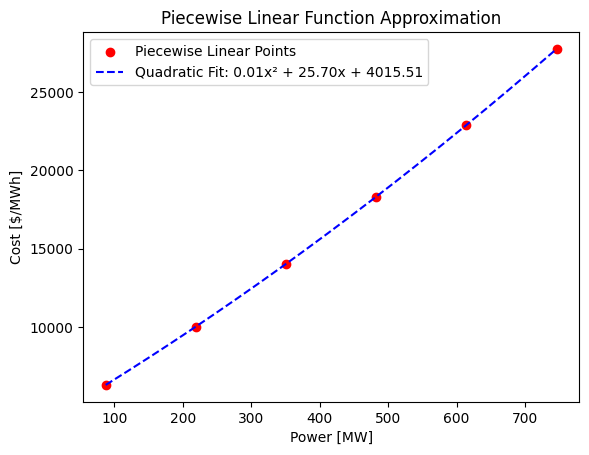

In [8]:
plt.style.use("default")
plt.scatter(x, y, color='red', label='Piecewise Linear Points')
plt.plot(x_fit, y_fit, color='blue', linestyle='--',
         label=f'Quadratic Fit: {a:.2f}x² + {b:.2f}x + {c:.2f}')
plt.legend()
plt.xlabel('Power [MW]')
plt.ylabel('Cost [$/MWh]')
plt.title('Piecewise Linear Function Approximation')
plt.show()

In [9]:
# Initialize lists to store the coefficients for each row
coefficients_list = []

# Loop through each row of the 2D array
for row in mpc['gencost']:
    # Extract x and y values for the current row
    x = np.array([row[i] for i in range(4, row.shape[0], 2)])
    y = np.array([row[i] for i in range(5, row.shape[0], 2)])
    
    # Perform quadratic fit
    coefficients = np.polyfit(x, y, 2)  # Returns [a, b, c]
    
    # Append the coefficients to the list
    coefficients_list.append(coefficients)

# Convert the list of coefficients to a NumPy array for easier handling
coefficients_array = np.array(coefficients_list)

Next, we can prepare a new MATPOWER case dictionary with the quadratic cost function.

In [10]:
gencost2 = np.concatenate((mpc['gencost'][:, 0:4], coefficients_array), axis=1)

gencost2[:, 0] = 2  # type of cost function
gencost2[:, 3] = 3  # number of coefficients

mpc2 = mpc.copy()
mpc2['gencost'] = gencost2

In [11]:
sp2 = ams.system.System()
ams.io.matpower.mpc2system(mpc2, sp2)

sp2.setup()

Zero Line parameters detected, adjusted to default values: amax, amin.
System set up in 0.0253 seconds.


True

In [12]:
sp3 = ams.load("./Texas7k_20210804_33.RAW",
               setup=False,
               no_output=True,)

Parsing input file "./Texas7k_20210804_33.RAW"...
Input file parsed in 1.3173 seconds.


In [13]:
stg_mp = set(sp2.StaticGen.get_all_idxes())
stg_raw = set(sp3.StaticGen.get_all_idxes())
stg_equal = stg_mp == stg_raw
stg_equal

True

The two cases have idential generators, so we can add generator costs to the PSSE read case.

In [14]:
for index, row in sp2.GCost.cache.df_in.iterrows():
    sp3.add(model='GCost', **row)

In [15]:
sp3.setup()

System set up in 0.0185 seconds.


True

Starting from AMS v1.0.6, there is a correction for the parameters ``amax`` and ``amin``. These parameters are utilized in the constraints ``alflb`` and ``alfub``. When ``amax`` and ``amin`` are zero, they are adjusted to 2pi and -2pi respectively.

In [16]:
sp3.DCOPF.run(solver='PIQP', ignore_dpp=True)

Building system matrices
Parsing OModel for <DCOPF>
Evaluating OModel for <DCOPF>
Finalizing OModel for <DCOPF>
<DCOPF> initialized in 0.5833 seconds.
<DCOPF> solved as optimal in 0.1218 seconds, converged in 19 iterations with PIQP.


True

In [17]:
ams.io.xlsx.write(sp3, 'Texas7k.xlsx', overwrite=True)

xlsx file written to "Texas7k.xlsx"


True

In [18]:
ams.io.json.write(sp3, 'Texas7k.json', overwrite=True)

JSON file written to "Texas7k.json"


True